In [260]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [261]:
# Download dataset (only once)
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

In [262]:
# Read only the desired columns from the CSV file
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv',
                usecols=[   'engine_displacement',
                            'horsepower',
                            'vehicle_weight',
                            'model_year',
                            'fuel_efficiency_mpg']
                )

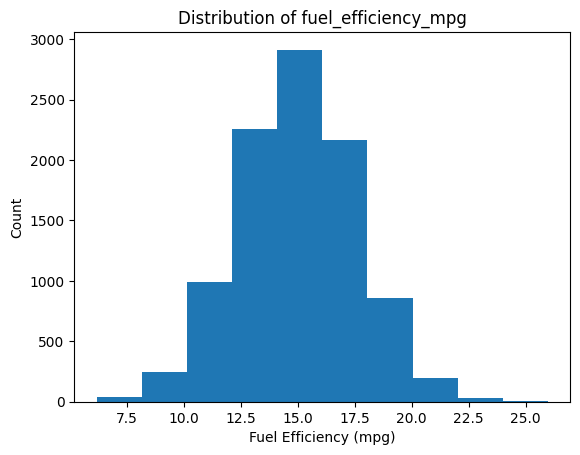

In [263]:
# Look at the fuel_efficiency_mpg variable. Does it have a long tail?
plt.hist(df.fuel_efficiency_mpg, bins=10)
plt.xlabel("Fuel Efficiency (mpg)")
plt.ylabel("Count")
plt.title("Distribution of fuel_efficiency_mpg")
plt.show()

# No, it does not have a long tail.


In [264]:
# Question 1: There's one column with missing values. What is it?
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [265]:
# Question 2: What's the median (50% percentile) for variable 'horsepower'?
df['horsepower'].median()

np.float64(149.0)

In [266]:
# Prepare and split the dataset
# Shuffle the dataset (the filtered one you created above), use seed 42.
np.random.seed(42)

# Split your data in train/val/test sets, with 60%/20%/20% distribution.
# Get dataset size
n = len(df)

# Compute split sizes
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

# Shuffle indices
idx = np.arange(n)
np.random.shuffle(idx)

# Shuffle dataframe
df_shuffled = df.iloc[idx]

# Split into train/val/test
df_train = df_shuffled.iloc[:n_train].reset_index(drop=True).copy()
df_val = df_shuffled.iloc[n_train:n_train + n_val].reset_index(drop=True).copy()
df_test = df_shuffled.iloc[n_train + n_val:].reset_index(drop=True).copy()

In [267]:
# Question 3: We need to deal with missing values for the column from Q1.
# Fill it with 0 
df_train_0 = df_train.copy()
df_val_0 = df_val.copy()
df_test_0 = df_test.copy()

df_train_0['horsepower'] = df_train_0['horsepower'].fillna(0)
df_val_0['horsepower'] = df_val_0['horsepower'].fillna(0)
df_test_0['horsepower'] = df_test_0['horsepower'].fillna(0)


# Fill it with the mean
df_train_mean = df_train.copy()
df_val_mean = df_val.copy()
df_test_mean = df_test.copy()

# For computing the mean, use the training only!
df_train_mean['horsepower'] = df_train_mean['horsepower'].fillna(df_train['horsepower'].mean())
df_val_mean['horsepower'] = df_val_mean['horsepower'].fillna(df_train['horsepower'].mean())
df_test_mean['horsepower'] = df_test_mean['horsepower'].fillna(df_train['horsepower'].mean())


In [268]:
# Try both options. For each, train a linear regression model without regularization using the code from the lessons.

# Get target values for Fillna(0)
y_train_0 = df_train_0.fuel_efficiency_mpg.values
y_val_0 = df_val_0.fuel_efficiency_mpg.values
y_test_0 = df_test_0.fuel_efficiency_mpg.values

# Drop target from feature set for Fillna(0)
del df_train_0['fuel_efficiency_mpg']
del df_val_0['fuel_efficiency_mpg']
del df_test_0['fuel_efficiency_mpg']

# Get target values for Fillna(mean)
y_train_mean = df_train_mean.fuel_efficiency_mpg.values
y_val_mean = df_val_mean.fuel_efficiency_mpg.values
y_test_mean = df_test_mean.fuel_efficiency_mpg.values

# Drop target from feature set for Fillna(mean)
del df_train_mean['fuel_efficiency_mpg']
del df_val_mean['fuel_efficiency_mpg']
del df_test_mean['fuel_efficiency_mpg']

In [269]:
def prepare_X(df, features):
    return df[features].values

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])  # bias term

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

In [270]:
features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

# Option 1: Fillna(0)
X_train = prepare_X(df_train_0, features)
X_val = prepare_X(df_val_0, features)
y_train = y_train_0
y_val = y_val_0

w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_val.dot(w)

rmse = np.sqrt(((y_val - y_pred) ** 2).mean())
rmse_0 = round(rmse, 2)
print("RMSE (fillna=0):", rmse)


# Option 2: Fillna(mean)
X_train = prepare_X(df_train_mean, features)
X_val = prepare_X(df_val_mean, features)
y_train = y_train_mean
y_val = y_val_mean

w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_val.dot(w)

rmse = np.sqrt(((y_val - y_pred) ** 2).mean())
rmse_mean = round(rmse, 2)
print("RMSE (fillna=mean):", rmse_mean)


RMSE (fillna=0): 0.5173782638857467
RMSE (fillna=mean): 0.46


In [271]:
# Question 3: Which option gives better RMSE?
if rmse_mean < rmse_0:
    print("Filling with MEAN gives better RMSE.")
elif rmse_mean > rmse_0:
    print("Filling with 0 gives better RMSE.")
else:
    print("Both are equally good")


Filling with MEAN gives better RMSE.


In [272]:
# Question 4: Now let's train a regularized linear regression.
# For this question, fill the NAs with 0.

def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

# Same as before, fill NAs with 0
X_train = prepare_X(df_train_0, features)
X_val = prepare_X(df_val_0, features)
y_train = y_train_0
y_val = y_val_0


In [273]:
# Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
# Use RMSE to evaluate the model on the validation dataset.
# Round the RMSE scores to 2 decimal digits.
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_scores = {}

for r in r_values:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w0 + X_val.dot(w)
    rmse = np.sqrt(((y_val - y_pred) ** 2).mean())
    rmse_scores[r] = round(rmse, 2)

rmse_scores


{0: np.float64(0.52),
 0.01: np.float64(0.52),
 0.1: np.float64(0.52),
 1: np.float64(0.52),
 5: np.float64(0.52),
 10: np.float64(0.52),
 100: np.float64(0.52)}

In [274]:
#Question 4: Which r gives the best RMSE? If multiple options give the same best RMSE, select the smallest r.
best_r = min(rmse_scores, key=lambda k: (rmse_scores[k], k))  # pick smallest r if tie
print(f"Best r = {best_r}, with RMSE = {rmse_scores[best_r]:.2f}")


Best r = 0, with RMSE = 0.52


In [275]:
# Question 5: We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
# Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
# For each seed, do the train/validation/test split with 60%/20%/20% distribution.

rmse_scores = []

for seed in range(10):
    # Shuffle and split 60/20/20
    n = len(df)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].reset_index(drop=True).copy()
    df_val = df_shuffled.iloc[n_train:n_train + n_val].reset_index(drop=True).copy()
    df_test = df_shuffled.iloc[n_train + n_val:].reset_index(drop=True).copy()

    # Fill the missing values with 0 and train a model without regularization.
    df_train = df_train.fillna(0)
    df_val = df_val.fillna(0)

    # Prepare data
    X_train = prepare_X(df_train, features)
    X_val = prepare_X(df_val, features)

    y_train = df_train[target].values
    y_val = df_val[target].values

    # Train model
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)

    # For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
    rmse = np.sqrt(((y_val - y_pred) ** 2).mean())
    rmse_scores.append(rmse)


In [276]:
# Question 5: What's the standard deviation of all the scores? To compute the standard deviation, use np.std. Round the result to 3 decimal digits (round(std, 3))
std = np.std(rmse_scores)
std_rounded = round(std, 3)

print("RMSE scores per seed:", [round(s, 3) for s in rmse_scores])
print("Standard deviation of RMSE:", std_rounded)

RMSE scores per seed: [np.float64(0.521), np.float64(0.521), np.float64(0.523), np.float64(0.516), np.float64(0.511), np.float64(0.528), np.float64(0.531), np.float64(0.509), np.float64(0.515), np.float64(0.513)]
Standard deviation of RMSE: 0.007


In [277]:
# Question 6: Split the dataset like previously, use seed 9.
np.random.seed(9)

# Combine train and validation datasets.
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].reset_index(drop=True).copy()
df_val = df_shuffled.iloc[n_train:n_train + n_val].reset_index(drop=True).copy()
df_test = df_shuffled.iloc[n_train + n_val:].reset_index(drop=True).copy()

In [278]:
# Fill the missing values with 0 and train a model with r=0.001.
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)

df_full_train = df_full_train.fillna(0)
df_test = df_test.fillna(0)

X_train = df_full_train[features].values
y_train = df_full_train[target].values
X_test = df_test[features].values
y_test = df_test[target].values

def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

w0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

y_pred = w0 + X_test.dot(w)


In [279]:
# Question 6: What's the RMSE on the test dataset?
rmse = np.sqrt(((y_test - y_pred) ** 2).mean())
print("RMSE on test data:", round(rmse, 2))

RMSE on test data: 0.52
